In [1]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
import numpy as np
from scipy.stats import ttest_ind

In [2]:
# Настройка отображения структур молекул
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True

In [3]:
# Загрузка данных
df = pd.read_csv('../data/processed/train_labels.csv')
print(f"Всего записей: {len(df)}")
print("\nПервые 5 строк данных:")
display(df.head())

Всего записей: 8221

Первые 5 строк данных:


,CASRN,SMILES,logLD50_mmolkg,verytoxic,toxic,EPA_category,GHS_category
0,23233-88-7,CC(=O)Oc1c(Br)cc(Cl)cc1C(=S)Nc1ccc(Br)cc1,0.810998,0.0,0.0,3.0,5.0
1,87-12-7,O=C(Nc1ccc(Br)cc1)c1cc(Br)ccc1O,0.043377,0.0,1.0,2.0,4.0
2,31810-89-6,Nc1cc(Br)c(O)c2c(O)c3c(N)cc(Br)c(O)c3c(O)c12,NaN,0.0,0.0,4.0,5.0
3,60012-87-5,O=C1OC(CBr)CC12CC(CBr)OC2=O,NaN,0.0,0.0,4.0,5.0
4,15435-29-7,Oc1c(Br)cc(Cl)cc1Cc1cc(Cl)cc(Br)c1O,0.937856,0.0,0.0,3.0,5.0


In [4]:
# Проверка данных
print("\nПропущенные значения:")
print(df.isnull().sum())


Пропущенные значения:
CASRN                0
SMILES               0
logLD50_mmolkg    2129
verytoxic            2
toxic               12
EPA_category        95
GHS_category        32
dtype: int64


In [5]:
print("\nОписательная статистика:")
print(df.describe())


Описательная статистика:
       logLD50_mmolkg    verytoxic        toxic  EPA_category  GHS_category
count     6092.000000  8219.000000  8209.000000   8126.000000   8189.000000
mean         0.444051     0.085534     0.567791      2.804701      4.109904
std          0.904205     0.279691     0.495413      0.848895      0.998233
min         -4.602647     0.000000     0.000000      1.000000      1.000000
25%          0.002672     0.000000     0.000000      2.000000      4.000000
50%          0.602976     0.000000     1.000000      3.000000      4.000000
75%          1.066246     0.000000     1.000000      3.000000      5.000000
max          2.708793     1.000000     1.000000      4.000000      5.000000


In [6]:
# Визуализация распределений
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Распределение logLD50')

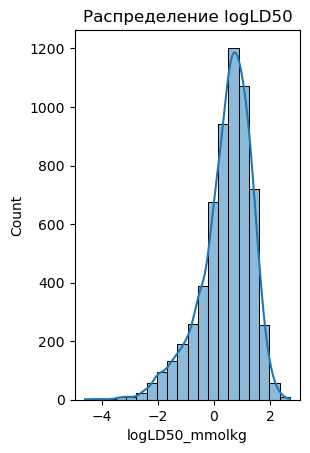

In [7]:
# Гистограмма logLD50
plt.subplot(1, 2, 1)
sns.histplot(df['logLD50_mmolkg'].dropna(), kde=True, bins=20)
plt.title('Распределение logLD50')

Text(0.5, 1.0, 'Доля очень токсичных соединений')

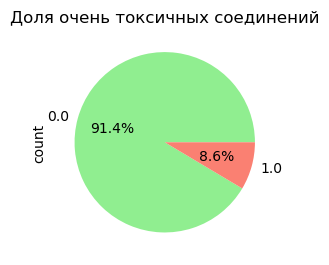

In [8]:
# Круговая диаграмма для verytoxic
plt.subplot(1, 2, 2)
df['verytoxic'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightgreen', 'salmon'])
plt.title('Доля очень токсичных соединений')

In [9]:
# Анализ категорий опасности
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

C:\Users\PC\AppData\Local\Temp\ipykernel_2120\1560195045.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='EPA_category', data=df, palette='viridis')


Text(0.5, 1.0, 'Распределение по категориям EPA')

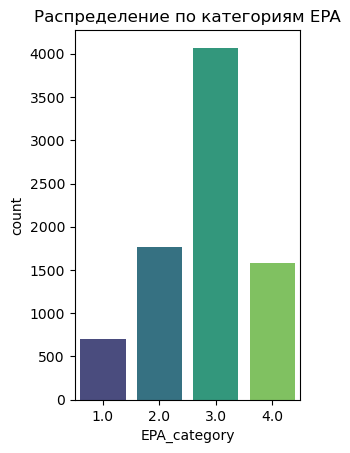

In [10]:
# EPA категории
plt.subplot(1, 2, 1)
sns.countplot(x='EPA_category', data=df, palette='viridis')
plt.title('Распределение по категориям EPA')

C:\Users\PC\AppData\Local\Temp\ipykernel_2120\119534391.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='GHS_category', data=df, palette='magma')


Text(0.5, 1.0, 'Распределение по категориям GHS')

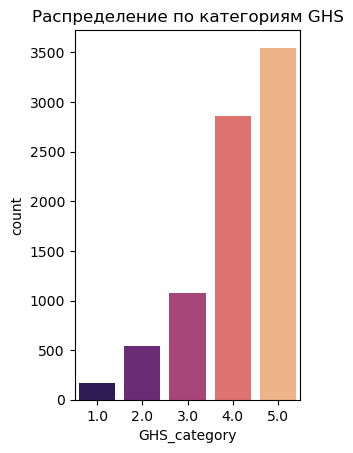

In [11]:
# GHS категории
plt.subplot(1, 2, 2)
sns.countplot(x='GHS_category', data=df, palette='magma')
plt.title('Распределение по категориям GHS')

In [12]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [13]:
# Корреляционный анализ (исключаем категориальные признаки)
corr_matrix = df[['logLD50_mmolkg', 'verytoxic', 'toxic']].corr()

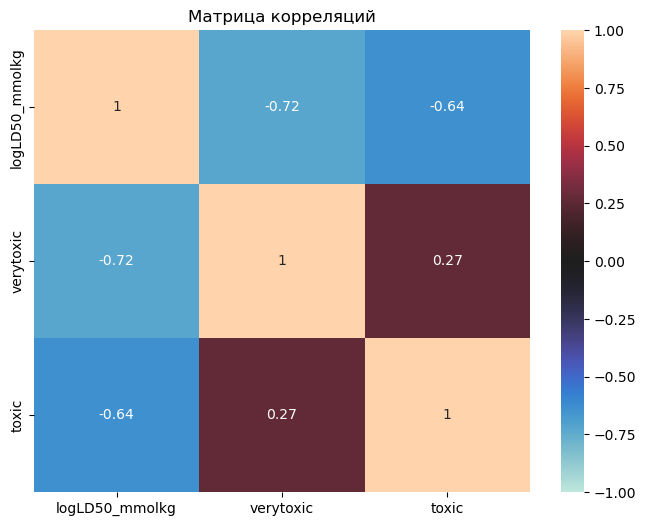

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='icefire', vmin=-1, vmax=1)
plt.title('Матрица корреляций')
plt.show()

In [15]:
# Анализ химических структур
def count_atoms(smiles, symbol):
    """Функция для подсчета атомов заданного типа в молекуле"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return 0
        return len([atom for atom in mol.GetAtoms() if atom.GetSymbol() == symbol])
    except:
        return 0

In [16]:
# Добавляем новые признаки
df['Cl_count'] = df['SMILES'].apply(lambda x: count_atoms(x, 'Cl'))
df['N_count'] = df['SMILES'].apply(lambda x: count_atoms(x, 'N'))
df['O_count'] = df['SMILES'].apply(lambda x: count_atoms(x, 'O'))

C:\Users\PC\AppData\Local\Temp\ipykernel_2120\2865546182.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='verytoxic', y='Cl_count', data=df, palette='Set2')


Text(0.5, 1.0, 'Содержание хлора')

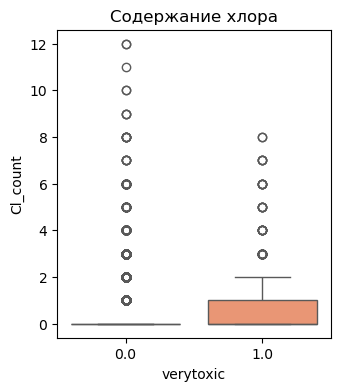

In [17]:
# Визуализация
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.boxplot(x='verytoxic', y='Cl_count', data=df, palette='Set2')
plt.title('Содержание хлора')

C:\Users\PC\AppData\Local\Temp\ipykernel_2120\2256965512.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='verytoxic', y='N_count', data=df, palette='Set3')


Text(0.5, 1.0, 'Содержание азота')

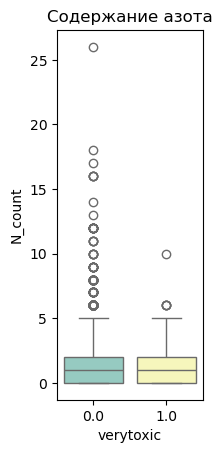

In [18]:
plt.subplot(1, 3, 2)
sns.boxplot(x='verytoxic', y='N_count', data=df, palette='Set3')
plt.title('Содержание азота')

C:\Users\PC\AppData\Local\Temp\ipykernel_2120\4127489331.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='verytoxic', y='O_count', data=df, palette='Set1')


Text(0.5, 1.0, 'Содержание кислорода')

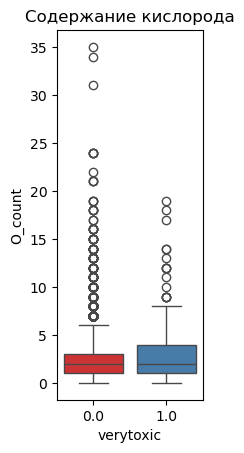

In [19]:
plt.subplot(1, 3, 3)
sns.boxplot(x='verytoxic', y='O_count', data=df, palette='Set1')
plt.title('Содержание кислорода')

In [20]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [21]:
# Визуализация структур молекул
sample = df.sample(4, random_state=42)
mols = [Chem.MolFromSmiles(s) for s in sample['SMILES']]
legends = [f"CASRN: {cas}\nlogLD50: {ld:.2f}" for cas, ld in zip(sample['CASRN'], sample['logLD50_mmolkg'])]

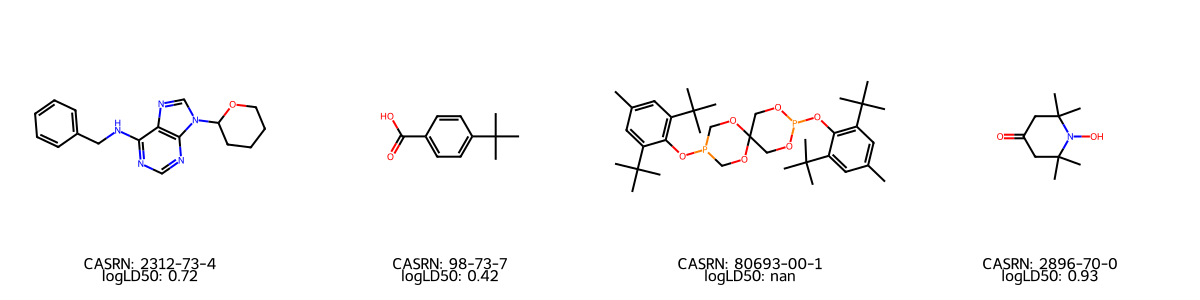

In [22]:
img = Draw.MolsToGridImage(
    mols,
    legends=legends,
    molsPerRow=4,
    subImgSize=(300, 300),
    useSVG=True
)
display(img)

In [23]:
# Статистический анализ
toxic_group = df.groupby('toxic')['logLD50_mmolkg'].mean()
print("Средние значения logLD50:")
print(toxic_group)

Средние значения logLD50:
toxic
0.0    1.291348
1.0    0.050546
Name: logLD50_mmolkg, dtype: float64


In [24]:
toxic = df[df['toxic'] == 1]['logLD50_mmolkg'].dropna()
non_toxic = df[df['toxic'] == 0]['logLD50_mmolkg'].dropna()

In [25]:
t_stat, p_value = ttest_ind(toxic, non_toxic)
print(f"\nРезультаты T-теста:")
print(f"t-статистика = {t_stat:.2f}")
print(f"p-value = {p_value:.4f}")


Результаты T-теста:
t-статистика = -64.77
p-value = 0.0000
